In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.nn import init

from torchvision.models.resnet import BasicBlock, ResNet
from torchvision.transforms import ToTensor

In [10]:
import io
from torchvision import models, transforms
import torch.utils.data as data_utils
from PIL import Image
import os

import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
def default_loader(path):
    return Image.open(path)   

In [11]:
from torchvision.models.resnet import BasicBlock, ResNet
from torch.nn import init

# custom convolutional layer that accounts for transposed image planes as well as conventional 2D conv layers
def conv(in_planes, out_planes, kernel_size=3, stride=1, dilation=1, bias=False, transposed=False):
    if transposed:
        layer = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1,
                                   dilation=dilation, bias=bias)
    else:
        padding = (kernel_size + 2 * (dilation - 1)) // 2
        layer = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias)
    if bias:
        init.constant(layer.bias, 0)
    return layer

# Returns 2D batch normalisation layer
# the range of activation values for each layer is "forced" to a normalized distribution of a static mean and cov value, mu & beta
# When the activations of a previous layer are forced to a normalized distribution, it makes training of subsequent layers much more efficient
def bn(planes):
    layer = nn.BatchNorm2d(planes)
    # Use mean 0, standard deviation 1 init
    init.constant(layer.weight, 1)
    init.constant(layer.bias, 0)
    return layer


# feature extraction using pretrained residual network - this performs as the decoder component of the architecture
# Resnet addresses the vanishing gradient problem for very deep networks, using skip connections between layers
class FeatureResNet(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 14, 16, 3], 1000)
        self.conv_f = conv(2,64, kernel_size=3,stride = 1)
        self.ReLu_1 = nn.ReLU(inplace=True)
        self.conv_pre = conv(512, 1024, stride=2, transposed=False)
        self.bn_pre = bn(1024)

    def forward(self, x):
        x1 = self.conv_f(x) #upsample 2 to 64
        x = self.bn1(x1)
        x = self.relu(x)
        x2 = self.maxpool(x) #maxpool with kernel size of 3 and add padding of 1
        x = self.layer1(x2) #identity sample 64 to 64
        x3 = self.layer2(x) #upsample 64 to 128
        x4 = self.layer3(x3) #upsample 128 to 256
        x5 = self.layer4(x4) #upsample 256 to 512
        x6 = self.ReLu_1(self.bn_pre(self.conv_pre(x5))) #upsample 512 to 1024
        return x1, x2, x3, x4, x5,x6


class SegResNet(nn.Module):
    def __init__(self, num_classes, pretrained_net):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU(inplace=True)
        self.conv3_2 = conv(1024, 512, stride=1, transposed=False)
        self.bn3_2 = bn(512)
        self.conv4 = conv(512,512, stride=2, transposed=True)
        self.bn4 = bn(512)
        self.conv5 = conv(512, 256, stride=2, transposed=True)
        self.bn5 = bn(256)
        self.conv6 = conv(256, 128, stride=2, transposed=True)
        self.bn6 = bn(128)
        self.conv7 = conv(128, 64, stride=2, transposed=True)
        self.bn7 = bn(64)
        self.conv8 = conv(64, 64, stride=2, transposed=True)
        self.bn8 = bn(64)
        self.conv9 = conv(64, 32, stride=2, transposed=True)
        self.bn9 = bn(32)
        self.convadd = conv(32, 16, stride=1, transposed=False)
        self.bnadd = bn(16)
        self.conv10 = conv(16, num_classes,stride=2, kernel_size=5)
        init.constant(self.conv10.weight, 0)  # Zero init

    def forward(self, x):
        
        '''
        At init, the FeatureResNet() method (aka "decoder") is used to extract features \
        from the input space and then those layer activation values are passed into the \
        encoder's conv layers to reduce dimensionality. Then this is done recursively \
        via gradient descent.
        '''
        x1, x2, x3, x4, x5, x6 = self.pretrained_net(x) #at init, this is used as feature extraction. Then, it's subsequently used as a decoder
        
        x = self.relu(self.bn3_2(self.conv3_2(x6)))
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        #print(x.size())
        x = self.relu(self.bn6(self.conv6(x+x4 )))
        #print(x.size())
        x = self.relu(self.bn7(self.conv7(x+x3 )))
        #print(x.size())
        x = self.relu(self.bn8(self.conv8(x+x2 )))
        #print(x.size())
        x = self.relu(self.bn9(self.conv9(x+x1 )))
        #print(x.size())
        x = self.relu(self.bnadd(self.convadd(x)))
        x = self.conv10(x)
        return x


In [12]:
fnet = FeatureResNet()
fcn = SegResNet(2,fnet)
fcn = fcn.cuda()


<ipython-input-11-53e96db55372>:22: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(layer.weight, 1)
<ipython-input-11-53e96db55372>:23: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(layer.bias, 0)
<ipython-input-11-53e96db55372>:72: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.conv10.weight, 0)  # Zero init


In [13]:
dataset_path = '/home/numairahmed/Deep-Dic-deep-learning-based-digital-image-correlation/image_data'
filename = "validation_dataset.txt"
mynumbers = []
with open(filename) as f:
    for line in f:
        item = line.strip().split('\n')
        for subitem in item:
            mynumbers.append(subitem)
            
test_set = []
for z in range(8001,8102):
    test_set.append((dataset_path+'/imgs4/train_image_'+str(z+1)+'_1.png',
                       dataset_path+'/imgs4/train_image_'+str(z+1)+'_2.png',
                       dataset_path+'/gt4/train_image_'+str(z+1)+'.mat'))

dataset_path = '/home/numairahmed/Deep-Dic-deep-learning-based-digital-image-correlation/image_data'
filename = "train_dataset.txt"
mynumbers = []
with open(filename) as f:
    for line in f:
        item = line.strip().split('\n')
        for subitem in item:
            mynumbers.append(subitem)
            
train_set = []
for z in range(12000,13001):
    train_set.append((dataset_path+'/imgs4/train_image_'+str(z+1)+'_1.png',
                       dataset_path+'/imgs4/train_image_'+str(z+1)+'_2.png',
                       dataset_path+'/gt4/train_image_'+str(z+1)+'.mat'))
    

In [14]:
import scipy.io as sio
#light_index_2 = [2,7,15,8,4,22,13,57,54,40,91,21,29,84,71,25,28,51,67,62,34,46,93,87]
class MyDataset(data_utils.Dataset):
    def __init__(self, dataset, transform=None, target_transform=None, loader=default_loader):
        '''
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0],int(words[1])))
            
        '''
 
        self.imgs = dataset
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        label_x, label_y, label_z = self.imgs[index]
        img1 = self.loader(label_x)
        img_1 = ToTensor()(img1.resize((128,128)))
        img2 = self.loader(label_y)
        img_2 = ToTensor()(img2.resize((128,128)))
        imgs = torch.cat((img_1, img_2), 0)
        try:
            gt = sio.loadmat(label_z)['Disp_field_1'].astype(float)
            
        except KeyError:
            gt = sio.loadmat(label_z)['Disp_field_2'].astype(float)
        
        # print(f"gt size before {gt.shape} ")
        gt = gt[::2,::2,:]
        # print(f"gt size before {gt.shape} ")
        gt = np.moveaxis(gt, -1, 0)
        # print(f"img1 {img_1.shape}\n img2 {img_2.shape}\n gt {gt.shape}\n  imgs {imgs.shape}\n")
        # print(f"img1 {img1.size}\n img2 {img2.size}\n")
        
        return imgs,gt

    def __len__(self):
        return len(self.imgs)

In [15]:
EPOCH = 100              # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 12
print('BATCH_SIZE = ',BATCH_SIZE)
LR = 0.001              # learning rate
#root = './gdrive_northwestern/My Drive/dl_encoder/data/orig/orig'
NUM_WORKERS = 0

optimizer = torch.optim.Adam(fcn.parameters(), lr=LR)   # optimize all cnn parameters
#optimizer = torch.optim.SGD(cnn.parameters(), lr=LR, momentum=0.9)   # optimize all cnn parameters
loss_func = nn.MSELoss()


train_data=MyDataset(dataset=train_set)
train_loader = data_utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_data=MyDataset(dataset=test_set)
test_loader = data_utils.DataLoader(dataset=test_data, batch_size=1)

BATCH_SIZE =  12


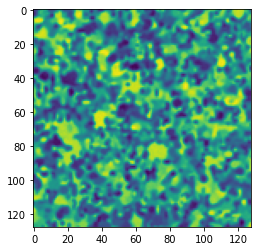

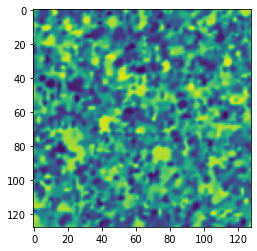

In [16]:
for (imgs,gt) in train_loader:
    plt.figure()
    plt.imshow(imgs[0][0])
    plt.figure()
    plt.imshow(imgs[0][1])
    break

In [9]:
from datetime import datetime
dataString = datetime.strftime(datetime.now(), '%Y_%m_%d_%H:%M:%S')

In [10]:
root_result = 'matlabData_1000x/'
os.mkdir(root_result)
model_result = root_result+'model/'
log_result = root_result+'log/'
os.mkdir(model_result)
os.mkdir(log_result)

In [11]:
fileOut=open(log_result+'log'+dataString,'a')
fileOut.write(dataString+'Epoch:   Step:    Loss:        Val_Accu :\n')
fileOut.close()
fileOut2 = open(log_result+'validation'+dataString, 'a')
fileOut2.write('kernal_size of conv_f is 2')
fileOut2.write(dataString+'Epoch:    loss:')



#fcn.load_state_dict(torch.load(model_result + 'param_all_1_99_1156'))
for epoch in range(EPOCH):
    fcn.train()
    for step, (img,gt) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        
        img = Variable(img).cuda()
        #gt=gt.unsqueeze(1).float()# batch x
        gt=gt.float()
        gt = Variable(gt).cuda()
        #b_y = Variable(y)#.cuda()   # batch y
        #print(img.size())
        #output = cnn(b_x)[0]               # cnn output
        output = fcn(img)               # cnn output
        # print(output.size())
        # print(gt.size())
        loss = loss_func(output, gt)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        print(epoch,  step, loss.data.item())
        fileOut=open(log_result+'log'+dataString,'a')
        fileOut.write(str(epoch)+'   '+str(step)+'   '+str(loss.data.item())+'\n')
        fileOut.close()
    if epoch%10 == 9:
        PATH = model_result + 'param_all_2_' + str(epoch) + '_' + str(step)
        torch.save(fcn.state_dict(), PATH)
        print('finished saving checkpoints')
     
    LOSS_VALIDATION = 0
    fcn.eval()
    with torch.no_grad():
        for step, (img,gt) in enumerate(test_loader):

            img = Variable(img).cuda()
            gt=gt.unsqueeze(1)# batch x
            gt = Variable(gt).cuda()
            output = fcn(img) 
            LOSS_VALIDATION += loss_func(output, gt)
        #print(LOSS_VALIDATION.data.item())
        LOSS_VALIDATION = LOSS_VALIDATION/step
        fileOut2 = open(log_result+'validation'+dataString, 'a')
        fileOut2.write(str(epoch)+'   '+str(step)+'   '+str(LOSS_VALIDATION.data.item())+'\n')
        fileOut2.close()
        print('validation error epoch  '+str(epoch)+':    '+str(LOSS_VALIDATION)+'\n'+str(step))


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 0 6.961779594421387
0 1 12.305655479431152
0 2 12.561500549316406
0 3 12.245996475219727
0 4 13.587774276733398
0 5 11.412412643432617
0 6 13.480326652526855
0 7 6.093859672546387
0 8 11.615579605102539
0 9 11.728487014770508
0 10 7.264335632324219
0 11 5.486875534057617
0 12 8.602409362792969
0 13 12.682096481323242
0 14 6.5540571212768555
0 15 6.378992080688477
0 16 13.747347831726074
0 17 7.723193168640137
0 18 8.158121109008789
0 19 10.026142120361328
0 20 8.650328636169434
0 21 8.08203125
0 22 7.725730895996094
0 23 9.407275199890137
0 24 7.7335309982299805
0 25 6.449830532073975
0 26 11.975260734558105
0 27 10.829839706420898
0 28 16.993118286132812
0 29 5.188893795013428
0 30 8.537918090820312
0 31 8.83633804321289
0 32 6.778319358825684
0 33 6.638052940368652
0 34 8.35398006439209
0 35 8.510221481323242
0 36 11.761195182800293
0 37 11.459920883178711
0 38 6.836284637451172
0 39 7.6056718826293945
0 40 15.4079008102417
0 41 9.017810821533203
0 42 10.391664505004883
0 43 6.4769

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 2, 128, 128])) that is different to the input size (torch.Size([1, 2, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


validation error epoch  0:    tensor(127.0980, device='cuda:0', dtype=torch.float64)
100
1 0 6.557979583740234
1 1 8.221071243286133
1 2 8.354352951049805
1 3 13.010096549987793
1 4 7.166451930999756
1 5 15.63970947265625
1 6 6.656390190124512
1 7 8.938697814941406
1 8 8.756904602050781
1 9 5.664579391479492
1 10 9.698888778686523
1 11 6.277974605560303
1 12 9.997360229492188
1 13 6.293932914733887
1 14 9.151381492614746
1 15 11.665388107299805
1 16 9.153194427490234
1 17 4.289519309997559
1 18 8.560483932495117
1 19 7.557826519012451
1 20 6.851184844970703
1 21 10.044132232666016
1 22 8.686727523803711
1 23 8.418180465698242
1 24 7.610032081604004
1 25 9.660867691040039
1 26 7.469983100891113
1 27 10.440719604492188
1 28 12.813047409057617
1 29 9.570719718933105
1 30 11.444051742553711
1 31 5.840100288391113
1 32 5.599961757659912
1 33 8.670634269714355
1 34 12.379085540771484
1 35 9.566619873046875
1 36 10.071853637695312
1 37 9.768558502197266
1 38 8.045377731323242
1 39 7.062553405